In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 2018-09-12 Getting started with pyNEST

In [2]:
from sklearn.svm import LinearSVC
from scipy.special import erf
import nest

# 1/ Neuron tutorial

In [3]:
neuron = nest.Create('iaf_psc_alpha')
print(nest.GetStatus(neuron, 'V_m'))
print(nest.GetStatus(neuron, 'V_th'))

(-70.0,)
(-55.0,)


In [4]:
#set background current intensity
nest.SetStatus(neuron, {"I_e": 376.}) #mind the float

#set up the recording
multimeter = nest.Create("multimeter")
nest.SetStatus(multimeter, {"withtime":True, "record_from":["V_m"]})

spikedetector = nest.Create("spike_detector",
                    params={"withgid": True, "withtime": True})

#you do have to connect the devices though
nest.Connect(multimeter, neuron)
nest.Connect(neuron, spikedetector)

nest.Simulate(1000.0)

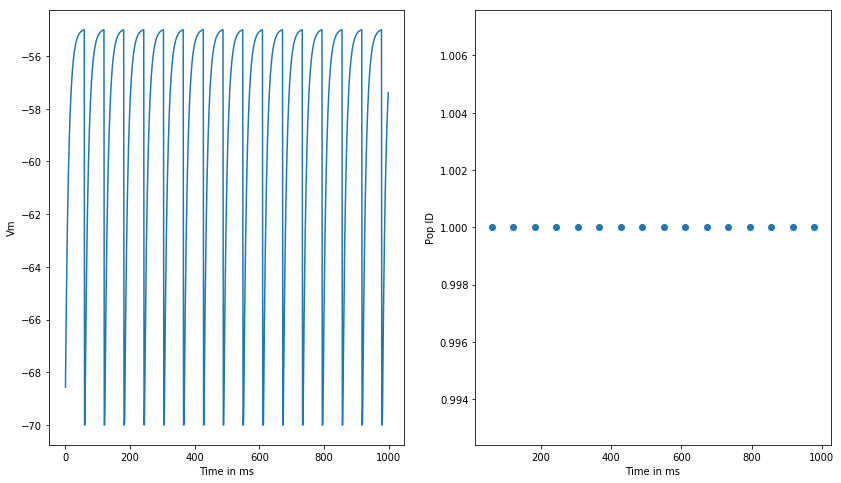

In [5]:
dmm = nest.GetStatus(multimeter)[0] #just one node so it's 0
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]

dSD = nest.GetStatus(spikedetector,keys="events")[0]
evs = dSD["senders"]
dts = dSD["times"]

import matplotlib.pyplot as plt

plt.figure(figsize = (14,8))
plt.subplot(121)
plt.plot(ts,Vms)
plt.xlabel('Time in ms')
plt.ylabel('Vm')

plt.subplot(122)
plt.scatter(dts, evs)
plt.xlabel('Time in ms')
plt.ylabel('Pop ID')

plt.show()

In [6]:
neuron = nest.Create('iaf_psc_alpha')
nest.SetStatus(neuron, {"I_e": 0.}) #cut the input in case NEST didn't reset the neuron

#with a poisson noise generator
noise_ex = nest.Create("poisson_generator")
noise_in = nest.Create("poisson_generator")
nest.SetStatus(noise_ex, {"rate": 80000.0})
nest.SetStatus(noise_in, {"rate": 15000.0})

#the noise_ex is an excitatory generator of 1.2pa, whereas in is an inhibitor of -2.0 pa
syn_dict_ex = {"weight": 1.2}
syn_dict_in = {"weight": -2.0}
nest.Connect(noise_ex, neuron, syn_spec=syn_dict_ex)
nest.Connect(noise_in, neuron, syn_spec=syn_dict_in)

#setup record
multimeter = nest.Create("multimeter")
nest.SetStatus(multimeter, {"withtime":True, "record_from":["V_m"]})

spikedetector = nest.Create("spike_detector",
                    params={"withgid": True, "withtime": True})

#you do have to connect the devices though
nest.Connect(multimeter, neuron)
nest.Connect(neuron, spikedetector)

nest.Simulate(1000)

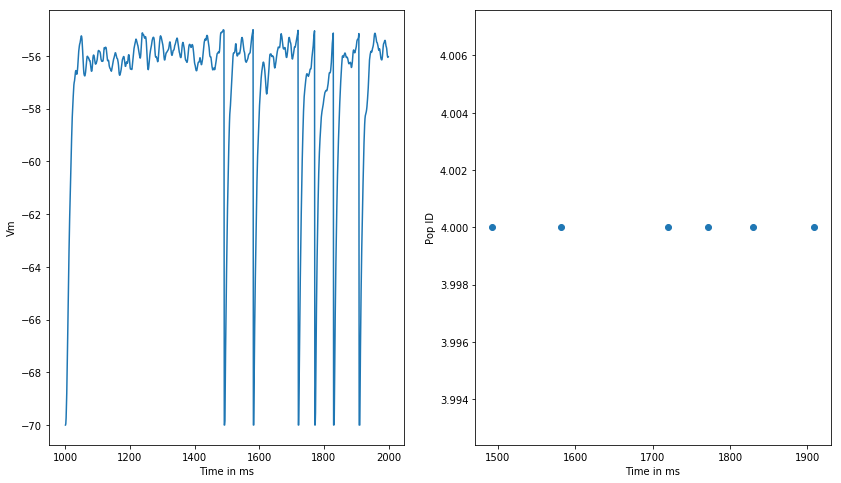

In [7]:
dmm = nest.GetStatus(multimeter)[0] #just one node so it's 0
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]

dSD = nest.GetStatus(spikedetector,keys="events")[0]
evs = dSD["senders"]
dts = dSD["times"]

import matplotlib.pyplot as plt

plt.figure(figsize = (14,8))
plt.subplot(121)
plt.plot(ts,Vms)
plt.xlabel('Time in ms')
plt.ylabel('Vm')

plt.subplot(122)
plt.scatter(dts, evs)
plt.xlabel('Time in ms')
plt.ylabel('Pop ID')

plt.show()

In [8]:
#adding a second neuron driven by the first one, himself driven by the poisson generators
neuron = nest.Create('iaf_psc_alpha')
neuron2 = nest.Create("iaf_psc_alpha")
nest.SetStatus(neuron, {"I_e": 0.}) #cut the input in case NEST didn't reset the neuron

#with a poisson noise generator
noise_ex = nest.Create("poisson_generator")
noise_in = nest.Create("poisson_generator")
nest.SetStatus(noise_ex, {"rate": 80000.0})
nest.SetStatus(noise_in, {"rate": 15000.0})

#the noise_ex is an excitatory generator of 1.2pa, whereas in is an inhibitor of -2.0 pa
syn_dict_ex = {"weight": 1.2}
syn_dict_in = {"weight": -2.0}
nest.Connect(noise_ex, neuron, syn_spec=syn_dict_ex)
nest.Connect(noise_in, neuron, syn_spec=syn_dict_in)



multimeter1 = nest.Create("multimeter")
nest.SetStatus(multimeter1, {"withtime":True, "record_from":["V_m"]})
multimeter2 = nest.Create("multimeter")
nest.SetStatus(multimeter2, {"withtime":True, "record_from":["V_m"]})


nest.Connect(neuron, neuron2, syn_spec = {"weight":200.0})
nest.Connect(multimeter1, neuron)
nest.Connect(multimeter2, neuron2)

nest.Simulate(1000)

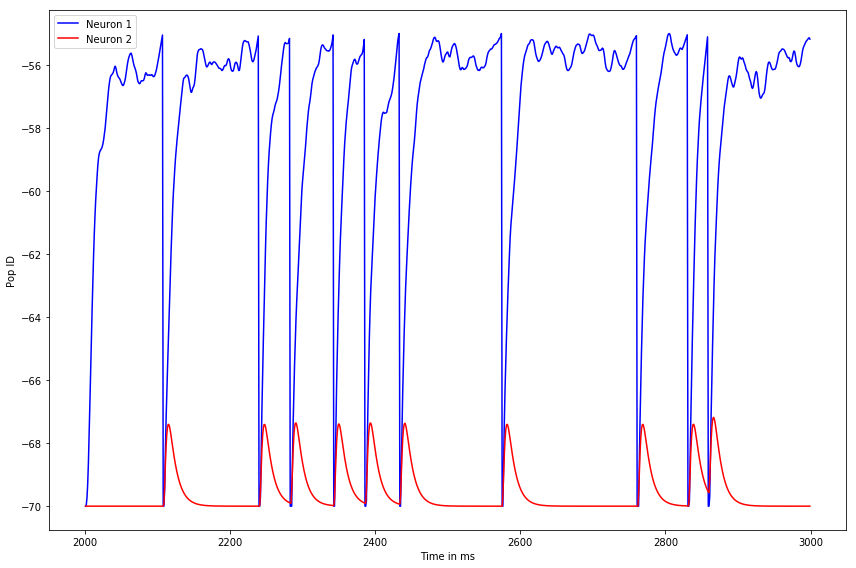

In [9]:
dmm = nest.GetStatus(multimeter1)[0] #yeah now i just realized we could have used a population-wise multimeter
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]

dmm2 = nest.GetStatus(multimeter2)[0]
Vms2 = dmm2["events"]["V_m"]
ts2 = dmm2["events"]["times"]

import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
plt.plot(ts,Vms, color = 'b', label = 'Neuron 1')
plt.xlabel('Time in ms')
plt.ylabel('Vm')

plt.plot(ts2, Vms2, color = 'r', label = 'Neuron 2')
plt.xlabel('Time in ms')
plt.ylabel('Pop ID')
plt.legend()
plt.tight_layout()
plt.show()

# 2/ Population of Neurons

In [10]:
#nest allows heterogenous population , just like you would create two in BRIAN
parameter_list = [{"I_e": 200.0, "tau_m": 20.0}, {"I_e": 150.0, "tau_m": 30.0}]
epop3 = nest.Create("iaf_psc_delta", 2, parameter_list)

import numpy as np
#nest also allows to loop through population to setup params
Vth = -55.
Vrest = -70.

for n in epop3 :
    nest.SetStatus([n], {'V_m' : Vrest+(Vth-Vrest)*np.random.rand()})

In [11]:
ndict = {"I_e": 200.0, "tau_m": 20.0}
epop1 = nest.Create("iaf_psc_alpha", 80, params = ndict)
epop2 = nest.Create("iaf_psc_alpha", 80, params = ndict)
ipop1 = nest.Create("iaf_psc_alpha", 20)
ipop2 = nest.Create("iaf_psc_alpha", 80)

nest.SetStatus(epop1, {"I_e" : 780.})

multimeter = nest.Create('multimeter', 20)
nest.SetStatus(multimeter, {'withtime':True, 'record_from':['V_m']})
multimeter2 = nest.Create('multimeter', 80)
nest.SetStatus(multimeter2, {'withtime':True, 'record_from':['V_m']})
nest.Connect(multimeter, ipop1)
nest.Connect(multimeter2, ipop2)

#fully connected population
nest.Connect(epop1, ipop1, syn_spec={'weight':20.0})
#one to one connection, works only if pop are of same size
nest.Connect(epop2, ipop2, 'one_to_one', syn_spec={'weight':20.0, "delay":1.0})

nest.Simulate(500)

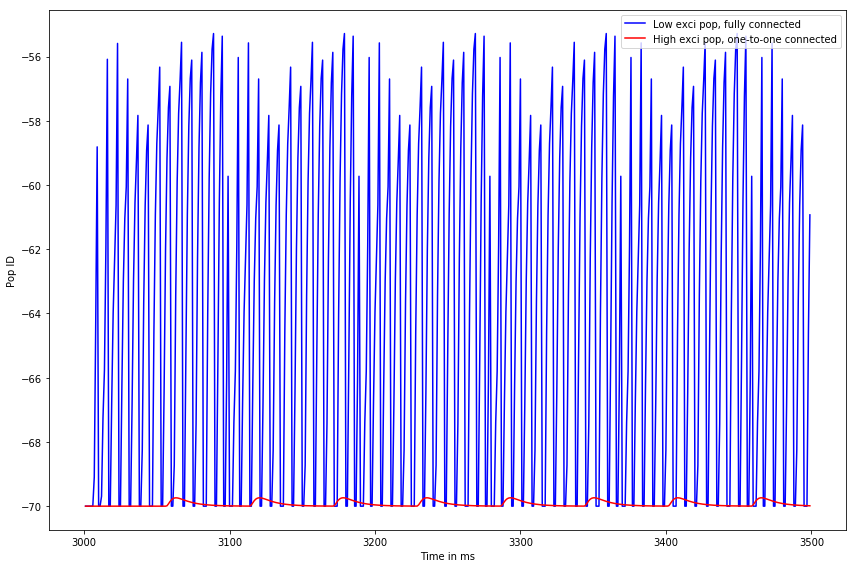

In [12]:
dmm = nest.GetStatus(multimeter)[0] 
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]

dmm2 = nest.GetStatus(multimeter2)[20]
Vms2 = dmm2["events"]["V_m"]
ts2 = dmm2["events"]["times"]

import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
plt.plot(ts,Vms, color = 'b', label = 'Low exci pop, fully connected')
plt.xlabel('Time in ms')
plt.ylabel('Vm')

plt.plot(ts2, Vms2, color = 'r', label = 'High exci pop, one-to-one connected')
plt.xlabel('Time in ms')
plt.ylabel('Pop ID')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
nest.ResetKernel()
#there is also the option of doing rule dictionnary for connectivity
epop1 = nest.Create("iaf_psc_alpha", 80, params = ndict)
epop2 = nest.Create("iaf_psc_alpha", 80, params = ndict)

forward_connexions = 12
backward_connexions = 5
con_dict_for = {'rule' : 'fixed_indegree', 'indegree':forward_connexions}
con_dict_back = {'rule' : 'fixed_indegree', 'indegree':backward_connexions}

dfor = 1.2
dback = 2.1
wfor = 5
wback = -2
syn_dict_for = {'delay' : dfor, 'weight' : wfor}
syn_dict_back = {'delay' : dback, 'weight' : wback}

nest.Connect(epop1, epop2, con_dict_for, syn_dict_for) #forward
nest.Connect(epop2, epop1, con_dict_back, syn_dict_back) #backward

#we trigger the first pop
nest.SetStatus(epop1, {"I_e" : 300.})

#and record both
multimeter = nest.Create('multimeter', 80)
nest.SetStatus(multimeter, {'withtime':True, 'record_from':['V_m']})
multimeter2 = nest.Create('multimeter', 80)
nest.SetStatus(multimeter2, {'withtime':True, 'record_from':['V_m']})
nest.Connect(multimeter, epop1)
nest.Connect(multimeter2, epop2)

nest.Simulate(500)

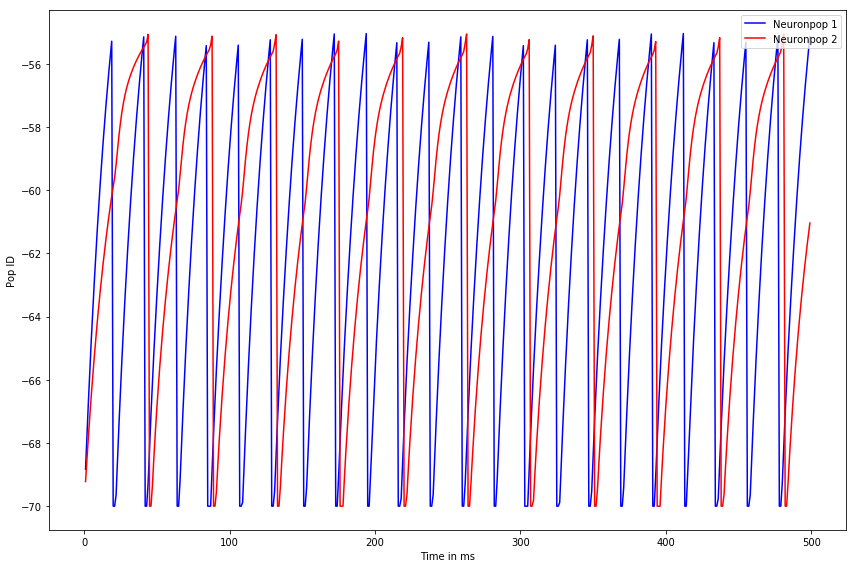

In [14]:
dmm = nest.GetStatus(multimeter)[0] 
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]

dmm2 = nest.GetStatus(multimeter2)[0]
Vms2 = dmm2["events"]["V_m"]
ts2 = dmm2["events"]["times"]

import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
plt.plot(ts,Vms, color = 'b', label = 'Neuronpop 1')
plt.xlabel('Time in ms')
plt.ylabel('Vm')

plt.plot(ts2, Vms2, color = 'r', label = 'Neuronpop 2')
plt.xlabel('Time in ms')
plt.ylabel('Pop ID')
plt.legend()
plt.tight_layout()
plt.show()

# 3/ Network connectivity

In [15]:
nest.ResetKernel()
#there is also the option of doing rule dictionnary for connectivity
epop1 = nest.Create("iaf_psc_alpha", 80, params = ndict)
epop2 = nest.Create("iaf_psc_alpha", 80, params = ndict)

forward_connexions = 12
backward_connexions = 5
con_dict_for = {'rule' : 'fixed_indegree', 'indegree':forward_connexions}
con_dict_back = {'rule' : 'fixed_indegree', 'indegree':backward_connexions}

#distributive parameters
dformin = .5
dbackmin = 1.2
dmax = 10.
wfor = 8
wback = -2
syn_dict_for = {'delay' : {"distribution":"uniform", "low":dformin, "high":dmax},
                'weight' : wfor}
syn_dict_back = {'delay' : {"distribution":"uniform", "low":dbackmin, "high":dmax},
                 'weight' : wback}

nest.Connect(epop1, epop2, con_dict_for, syn_dict_for) #forward
nest.Connect(epop2, epop1, con_dict_back, syn_dict_back) #backward

#we trigger the first pop
nest.SetStatus(epop1, {"I_e" : 300.})

#and record both
multimeter = nest.Create('multimeter', 80)
nest.SetStatus(multimeter, {'withtime':True, 'record_from':['V_m']})
nest.Connect(multimeter, epop2)

nest.Simulate(500)

In [16]:
%matplotlib inline

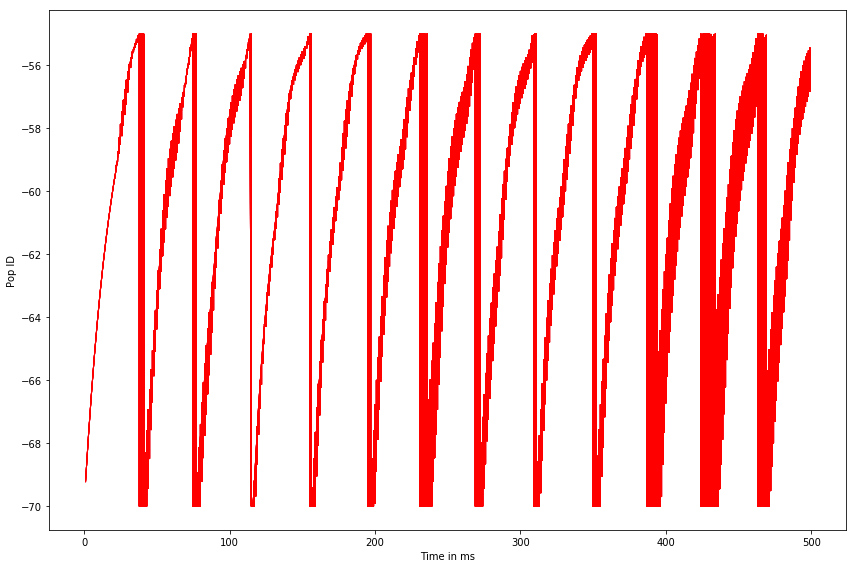

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (12,8))
jet= plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,80,10)))

traces = np.linspace(0, 70, 10)
for i in traces:
    dmm = nest.GetStatus(multimeter)[int(i)] 
    Vms = dmm["events"]["V_m"]
    ts = dmm["events"]["times"]
    plt.plot(ts,Vms, color = next(colors), lw = 1)
    
plt.xlabel('Time in ms')
plt.ylabel('Pop ID')
plt.tight_layout()
plt.show()

In [18]:
nest.GetConnections(epop1, epop2)

(array('l', [1, 112, 0, 0, 0]),
 array('l', [1, 114, 0, 0, 1]),
 array('l', [1, 152, 0, 0, 2]),
 array('l', [1, 82, 0, 0, 3]),
 array('l', [1, 157, 0, 0, 4]),
 array('l', [1, 141, 0, 0, 5]),
 array('l', [1, 99, 0, 0, 6]),
 array('l', [1, 105, 0, 0, 7]),
 array('l', [1, 92, 0, 0, 8]),
 array('l', [1, 83, 0, 0, 9]),
 array('l', [1, 159, 0, 0, 10]),
 array('l', [1, 83, 0, 0, 11]),
 array('l', [2, 113, 0, 0, 12]),
 array('l', [2, 104, 0, 0, 13]),
 array('l', [2, 113, 0, 0, 14]),
 array('l', [2, 150, 0, 0, 15]),
 array('l', [2, 108, 0, 0, 16]),
 array('l', [2, 117, 0, 0, 17]),
 array('l', [2, 93, 0, 0, 18]),
 array('l', [2, 112, 0, 0, 19]),
 array('l', [2, 142, 0, 0, 20]),
 array('l', [2, 143, 0, 0, 21]),
 array('l', [2, 85, 0, 0, 22]),
 array('l', [2, 101, 0, 0, 23]),
 array('l', [3, 121, 0, 0, 24]),
 array('l', [3, 129, 0, 0, 25]),
 array('l', [3, 153, 0, 0, 26]),
 array('l', [3, 146, 0, 0, 27]),
 array('l', [3, 136, 0, 0, 28]),
 array('l', [3, 87, 0, 0, 29]),
 array('l', [3, 154, 0, 0, 3